In [1]:
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as mpatches
import matplotlib, collections
from scipy.stats import norm
import imp, os, pickle
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings("ignore")
from matplotlib import collections  as mc

sns.set(style="darkgrid")
colors = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
print "Setting random seeds"

Setting random seed to 0


In [2]:
cluster_distance = np.load('../datasets/rnaseq/cluster_1_20k_dist_l1.npy')
best_arm = cluster_distance.argmin()
best = cluster_distance[:,best_arm]
n = cluster_distance.shape[0]
cluster_distance_f = cluster_distance.flatten()
estimate = np.mean(cluster_distance, axis=0)
print estimate.shape

(20000,)


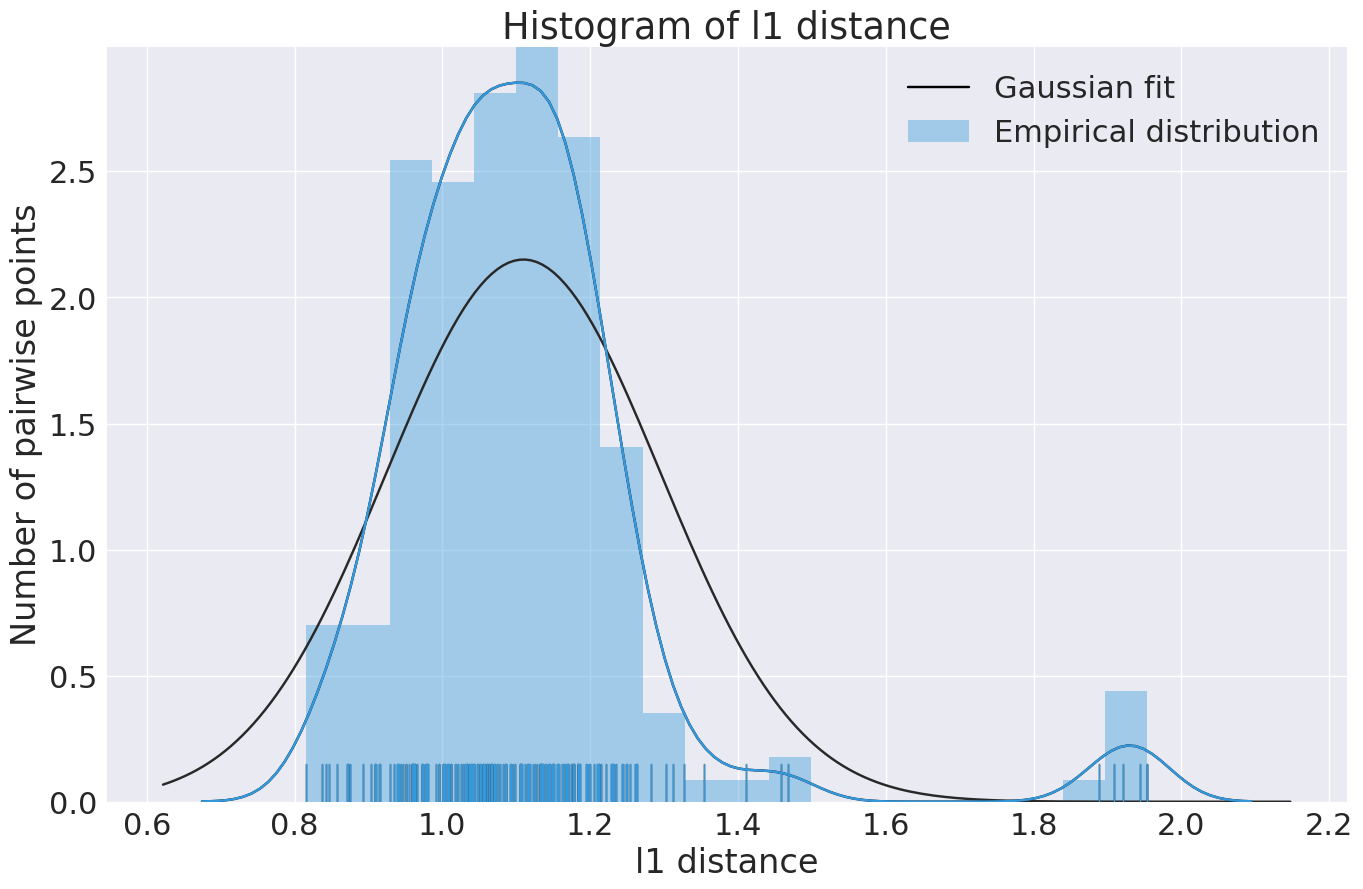

In [3]:
np.random.seed(0)
plt.figure(figsize=(16,10))
sns.set(font_scale = 2.2)
x = np.random.choice( cluster_distance_f, size=200,)
x = x[x.nonzero()]
fig = sns.distplot(x, fit=norm, color='black', rug=True,hist=False, bins=20, label="Gaussian fit")
fig = sns.distplot(x, norm_hist=True, color=colors[1], rug=True, bins=20, label="Empirical distribution")
fig.set(xlabel="l1 distance",  ylabel="Number of pairwise points" )
fig.set_title("Histogram of l1 distance")
fig.legend()
plt.show()

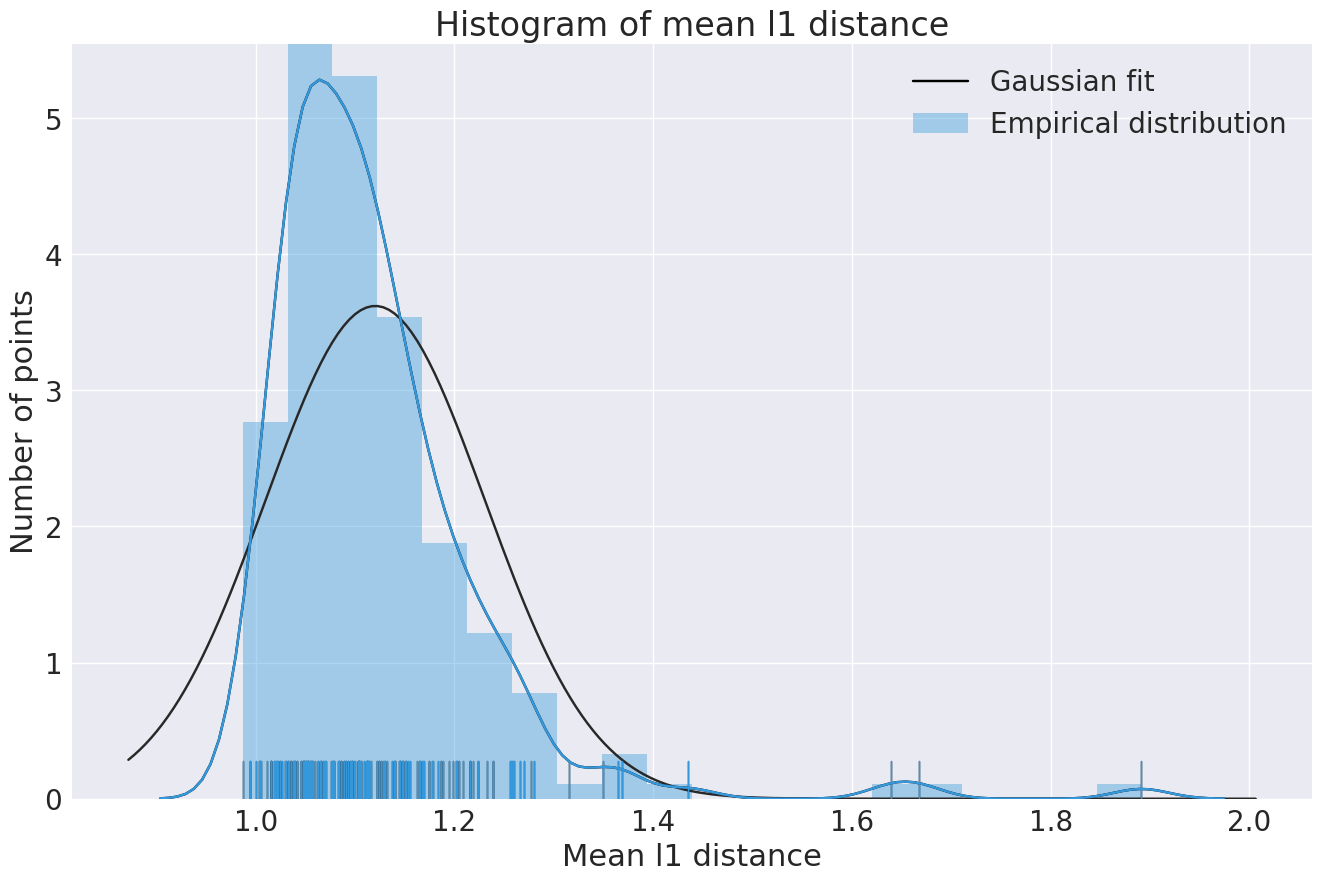

In [4]:
np.random.seed(1)
plt.figure(figsize=(16,10))
sns.set(font_scale = 2)
x = np.random.choice( estimate, size=2000,)
fig = sns.distplot(x, fit=norm, color='black', rug=True,hist=False, bins=20, label="Gaussian fit")
fig = sns.distplot(x, norm_hist=True, color=colors[1], rug=True, bins=20, label="Empirical distribution")
fig.set(xlabel="Mean l1 distance", ylabel="Number of points" )
fig.set_title("Histogram of mean l1 distance")


fig.legend()
plt.show()

0 2575
1 6637
2 11798
3 18898


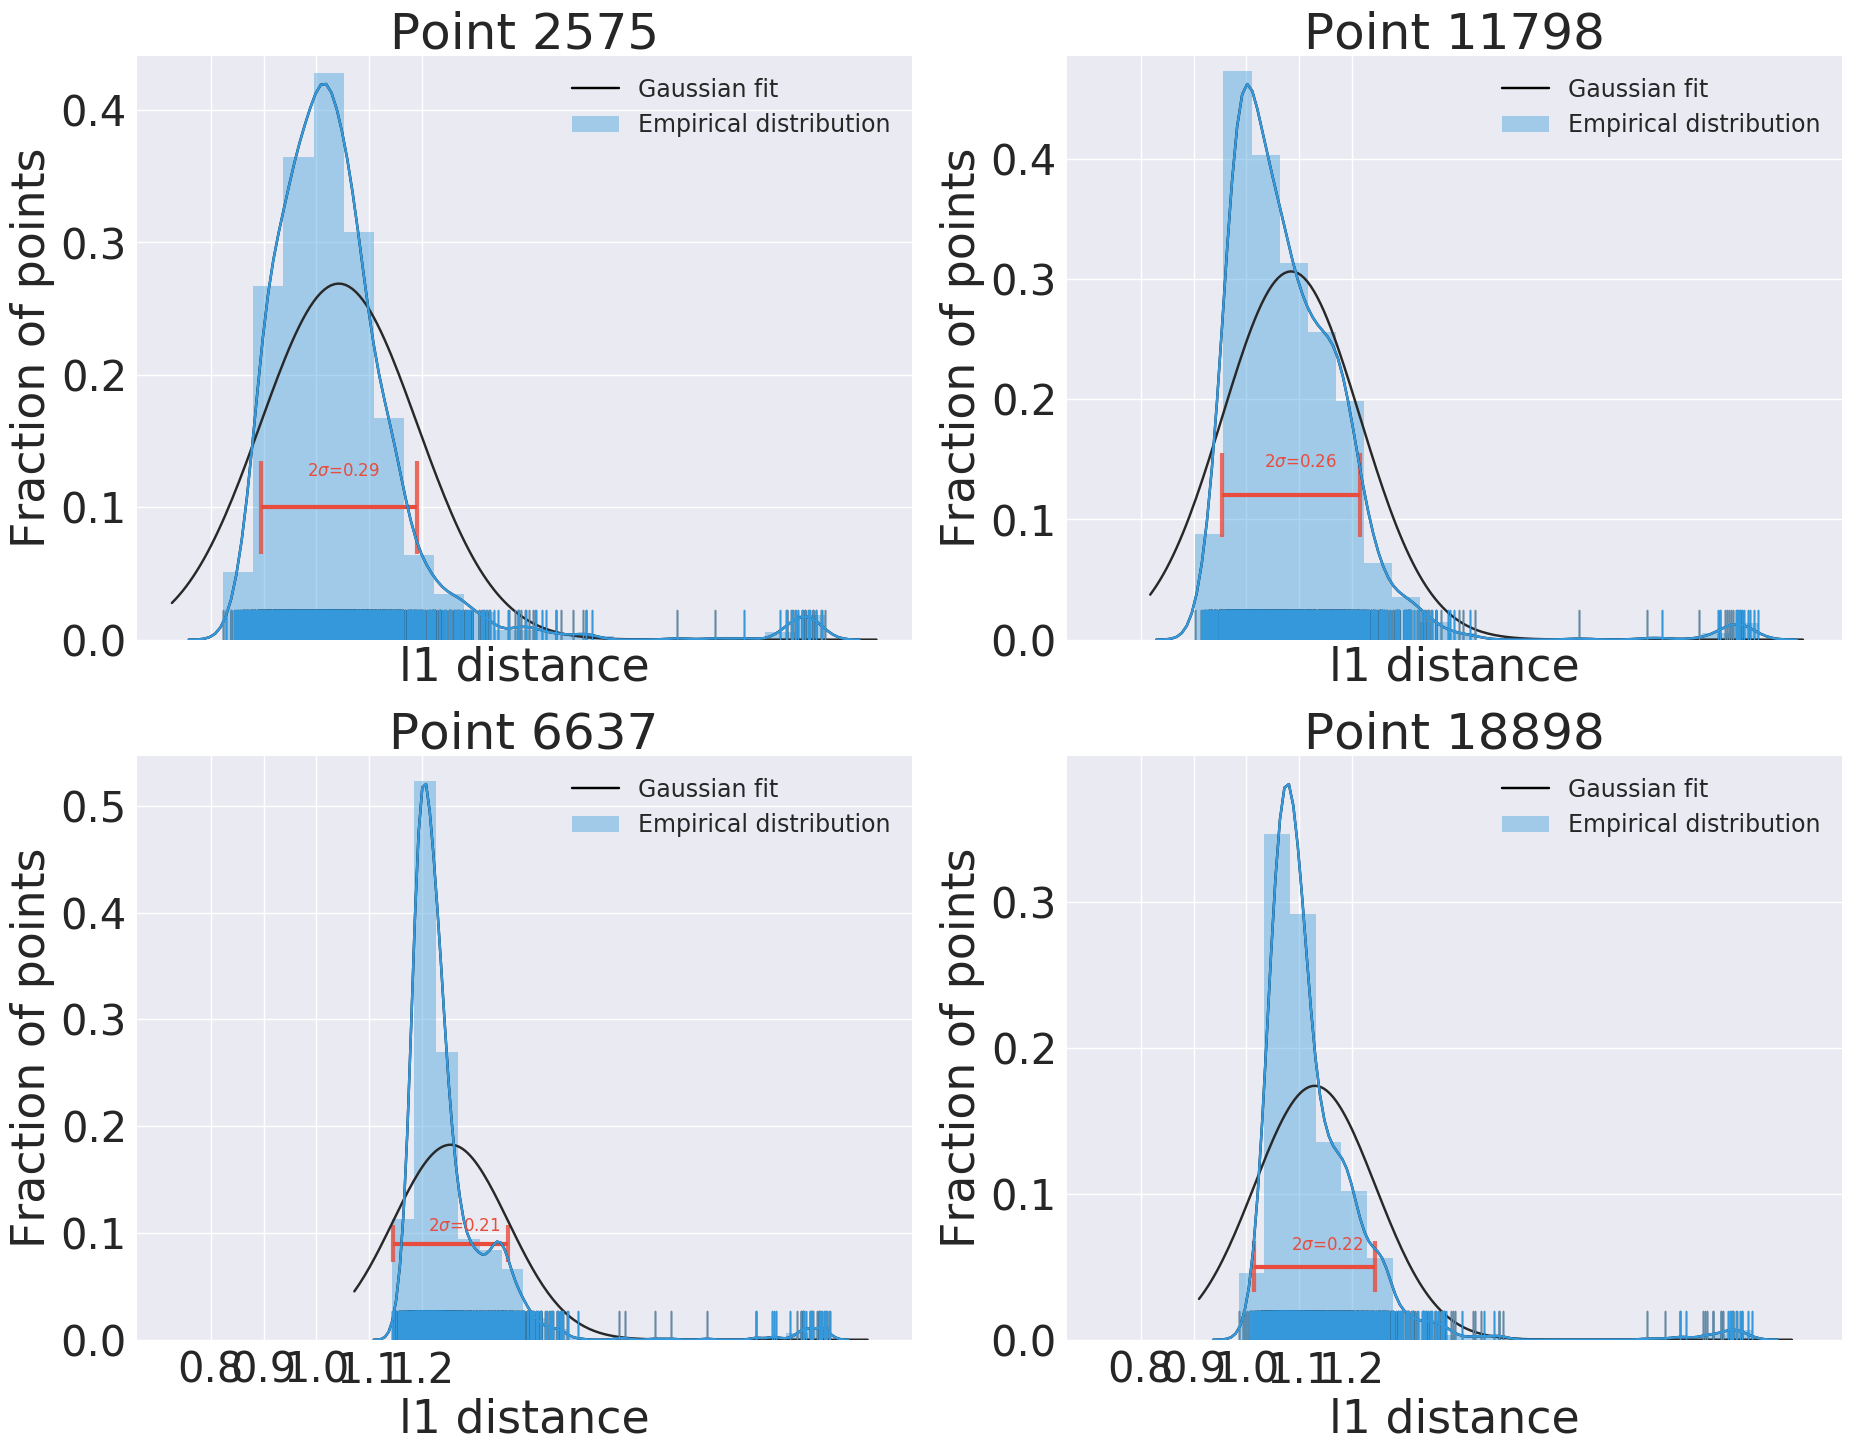

In [21]:
np.random.seed(2)
s = 2
indices = np.random.randint(n,size=4)
h_pos_array = [1,1.8,1.2,1]
indices.sort()
f, axes = plt.subplots(s, s, figsize=(22, 17), sharex=True)
sns.set(font_scale = 3)

for i in range(s*s):
    index = indices[i]
    print i, index
    #Sampling only 1000 points for each randomly chosen point to reduce computation time
    data = cluster_distance[:,index]
    data = np.random.choice( data, size=2000,)
    data = data[data.nonzero()]
    fig = sns.distplot(data, fit=norm, color='black', rug=True, 
                       hist=False, bins=20, label="Gaussian fit", ax=axes[i%s, i/s])
    fig = sns.distplot(data, norm_hist=True, color=colors[1], rug=True, 
                       bins=20, label="Empirical distribution", ax=axes[i%s, i/s])
    fig.set(xlabel="l1 distance",  ylabel="Fraction of points" )
    fig.set_xticks(np.arange(0.8, 1.25, .1))
    fig.set_yticklabels(np.arange(0,1,.1))

    gap =  .7
    h_pos = h_pos_array[i]
    h_lines = [ [(data.mean()-data.std(), h_pos), (data.mean()+data.std(), h_pos)] ]
    v_lines = [ [(data.mean()-data.std(), h_pos-gap/2), (data.mean()-data.std(), h_pos+gap/2)],
                [(data.mean()+data.std(), h_pos-gap/2), (data.mean()+data.std(), h_pos+gap/2)]  ]
    h_lc = mc.LineCollection(h_lines, linewidths=3, colors=colors[3], alpha=1)
    fig.add_collection(h_lc)
    v_lc = mc.LineCollection(v_lines, linewidths=3, colors=colors[3], alpha=.8)
    fig.add_collection(v_lc)
    two_sigma = int(2*data.std()*100)/100.
    fig.text(data.mean()-data.std()*.400, h_pos+gap/3, "$2\sigma$="+str(two_sigma), fontsize=12, color=colors[3])

    
    
    fig.legend(loc=1, prop={'size': 17})
    fig.set_title("Point "+str(index))

In [14]:
best_arm = 7374

"RAND Accuracy"
random_folder = '../experiments/rnaseq20k/rand/'
truths = np.zeros((47,))
for flname in os.listdir(random_folder):
    if not flname.endswith('.pkl'):
        continue
    with open(random_folder+flname,'rb') as f:
        x=pickle.load(f)
        truths += [z[0]==best_arm for z in x]    
truths = np.array(truths)/(len(os.listdir(random_folder))+0.0)

"meddit Accuracy"
mab_folder = '../experiments/rnaseq20k/meddit/'
mab = []
m = 15000
print len(os.listdir(mab_folder))
for flname in os.listdir(mab_folder):
    with open(mab_folder+flname,'rb') as f:
        x=pickle.load(f)
        answer = x[0][:np.where(x[0]==0)[0][0]]
        accuracy = np.pad(answer==best_arm, (0,m-len(answer)), 'edge')
        mab += [accuracy]
mab_error = 1-np.array(mab).mean(axis=0)
mab_arm = 32+np.arange(0, mab_error.shape[0])*32*32/20000.0

189
176.pkl


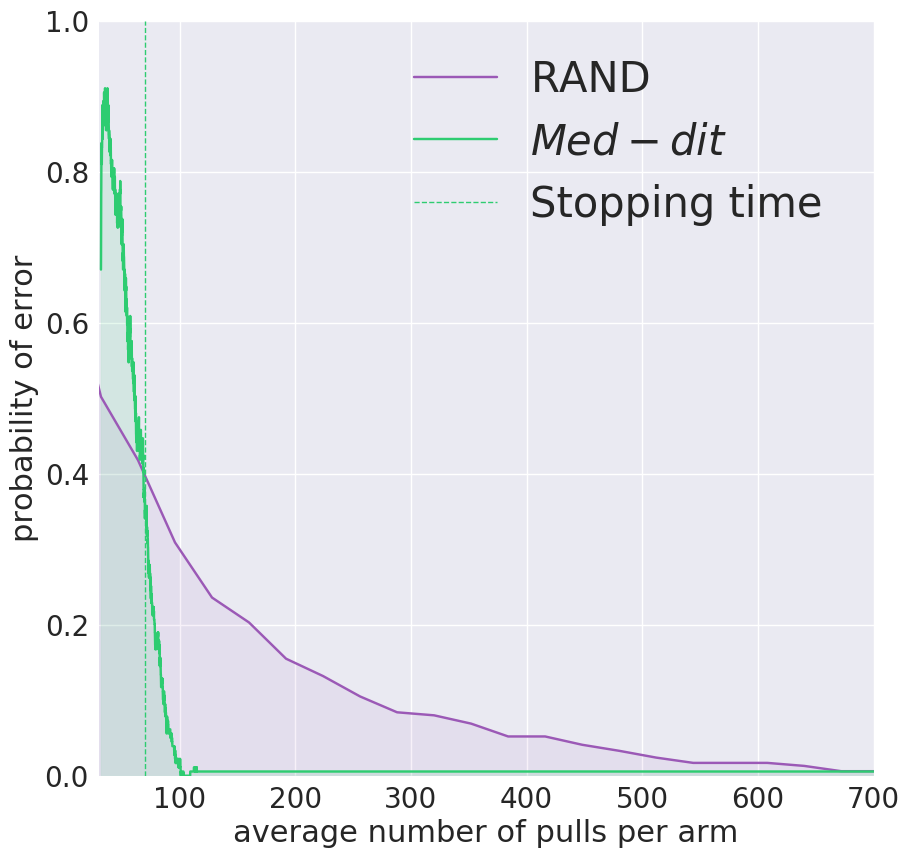

In [9]:
mab_avg_stopping_time = 70
fig = plt.figure(figsize=(10,10))
sns.set(font_scale = 2)
xaxis = np.arange(len(truths))*32
mab_arm[-1] = xaxis[-1]
plt.plot(xaxis, 1-truths, label='RAND', color=colors[0])
plt.fill_between(xaxis, 1-truths,0, color=colors[0], alpha=0.08)
plt.plot(mab_arm, mab_error, label='$Med-dit$',  color=colors[-1])
plt.fill_between(mab_arm, mab_error,0,  color=colors[-1],alpha=0.12)
plt.axvline(mab_avg_stopping_time, linestyle='--', lw=1, color=colors[-1], label="Stopping time ")
plt.legend(prop={'size': 30})
plt.xlabel('average number of pulls per arm')
plt.ylabel('probability of error')
plt.xlim((30,700))
plt.ylim((0,1))
plt.show()